# Text Classification using fine-tuned GPT-2 model


Task: Demonstrate how to use pre-trained GPT-2 model from Huggingface to perform text classification task.

## Install and import packages

In [1]:
# !pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
# !pip3 install pandas
# !pip3 install numpy
# !pip3 install sklearn
# !pip3 install tqdm
# !pip3 install transformers

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Read Data

Using [BBC news classification dataset](http://mlg.ucd.ie/datasets/bbc.html). The dataset can be downloaded from [Kaggle](https://www.kaggle.com/c/learn-ai-bbc/data).

In [3]:
df = pd.read_csv('./data/bbc-text.csv')

In [4]:
print('Columns:', df.columns)
print('Shape:',df.shape)


Columns: Index(['category', 'text'], dtype='object')
Shape: (2225, 2)


In [5]:
print(df.category.unique())

['tech' 'business' 'sport' 'entertainment' 'politics']


This dataset is in CSV format and it has 2125 different texts, each labeled under one of 5 categories: entertainment, sport, tech, business, or politics. It has two columns, category which will be the label; and text which will be our input data for GPT-2.

<Axes: xlabel='category'>

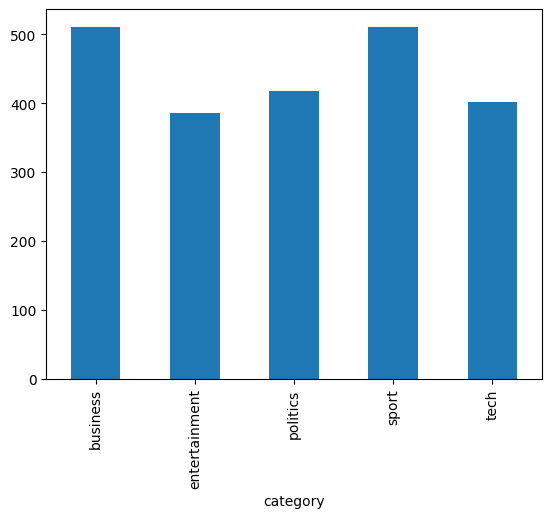

In [6]:
df.groupby("category").size().plot.bar()

## Data Preprocessing

We need to tokenize the input text in order to feed GPT-2 model with its expected data format. This can be easily done using HuggingFace Transformers' GPT2Tokenizer object. GPT2 uses last token for prediction. So we need to do padding to the left.

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token


In [8]:
example_text = "Germany won the football match."
gpt2_input = tokenizer(example_text, padding="max_length", max_length=10, truncation=True, return_tensors="pt")

In [9]:

print(gpt2_input['input_ids'])

tensor([[50256, 50256, 50256, 50256, 27079,  1839,   262,  4346,  2872,    13]])


In [10]:
print(gpt2_input["attention_mask"])

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1, 1]])


In [11]:
example_text = tokenizer.decode(gpt2_input.input_ids[0])
print(example_text)

<|endoftext|><|endoftext|><|endoftext|><|endoftext|>Germany won the football match.


In [12]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
labels = {
    "business": 0,
    "entertainment": 1,
    "sport": 2,
    "tech": 3,
    "politics": 4
         }

## Dataset class

 Defining custom Dataset class to read in news text, tokenize them, and store them into containers for batch training.

In [13]:


class Dataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                                padding='max_length',
                                max_length=128,
                                truncation=True,
                                return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def get_batch_labels(self, idx):
        # Get a batch of labels
        return np.array(self.labels[idx])
    
    def get_batch_texts(self, idx):
        # Get a batch of inputs
        return self.texts[idx]
    
    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y

Splitting data into training, validation and test data

In [14]:
df_train,df_test_val = train_test_split(df, test_size=0.2)
df_val, df_test = train_test_split(df_test_val, test_size=0.5)
print(len(df_train), len(df_val), len(df_test))

1780 222 223


## Model Building 

We buid a classifier model on top of a pre-trained GPT-2 model. Then add a linear layer on top of GPT-2's 12 layers of decoders with its output dimension equals the number of classes. In this way we can use GPT-2 to output 5 numbers which corresponds to our five news categories!

In [15]:
class SimpleGPT2SequenceClassifier(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2SequenceClassifier,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes)

        
    def forward(self, input_id, mask):
        """
        Args:
                input_id: encoded inputs ids of sent.
        """
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

## Model Training

Fine-tuning the model. Using cross entropy as the loss function and Adam optimizer.

In [16]:
def train(model, train_data, val_data, learning_rate, epochs):
    train, val = Dataset(train_data), Dataset(val_data)
    
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0
        
        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)
            
            model.zero_grad()

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()
            
        total_acc_val = 0
        total_loss_val = 0
        
        with torch.no_grad():
            
            for val_input, val_label in val_dataloader:
                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)
                
                output = model(input_id, mask)
                
                batch_loss = criterion(output, val_label)
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1)==val_label).sum().item()
                total_acc_val += acc
                
            print(
            f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")
            
EPOCHS = 1
model = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
LR = 1e-5

train(model, df_train, df_val, LR, EPOCHS)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 890/890 [01:26<00:00, 10.33it/s]


Epochs: 1 | Train Loss:  0.235             | Train Accuracy:  0.865             | Val Loss:  0.062             | Val Accuracy:  0.959


## Evaluation

In [17]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

        
    # Tracking variables
    predictions_labels = []
    true_labels = []
    
    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
            
            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels
    
true_labels, pred_labels = evaluate(model, df_test)

Test Accuracy:  0.978


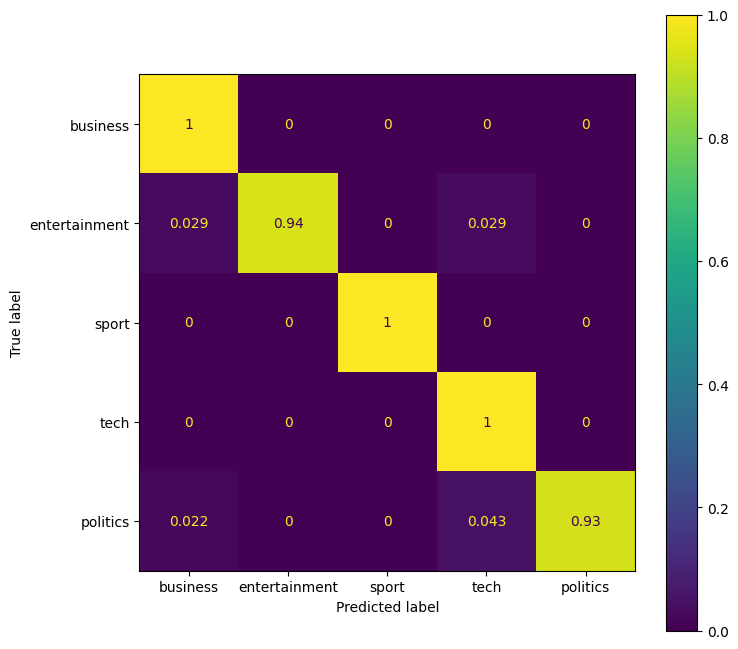

In [18]:
# Plot confusion matrix.
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true=true_labels, y_pred=pred_labels, labels=range(len(labels)), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.keys()))
disp.plot(ax=ax)

To save and load trained model

In [19]:
# save trained model
torch.save(model.state_dict(), "./model/gpt2-text-classifier-model.pt")

In [20]:
# load trained model
model_new = SimpleGPT2SequenceClassifier(hidden_size=768, num_classes=5, max_seq_len=128, gpt_model_name="gpt2")
model_new.load_state_dict(torch.load("./model/gpt2-text-classifier-model.pt"))
model_new.eval()

SimpleGPT2SequenceClassifier(
  (gpt2model): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dr

## Model Inference

In [21]:
example_text = """
uk athletics agrees new kit deal uk athletics has agreed a new deal with adidas to supply great britain squads of all ages with their kit for the next four years. The German-based firm kitted out team GB at the 2004 Olympics and has deals with 20 other national Olympic bodies. UK athletics chief David Moorcroft said: The Athens experience can now be extended to more major championships. in the year ahead these include the European indoor and world outdoor championships. we are delighted. moorcroft added: it is hugely beneficial to the sport that the adidas commitment will also provide for officials and other personnel at our world-class series of live televised events.

"""


tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token

model_input = tokenizer(example_text.lower(), padding='max_length', max_length=128, truncation=True, return_tensors="pt")

In [22]:
mask = model_input['attention_mask'].cpu()
input_id = model_input["input_ids"].squeeze(1).cpu()

output = model_new(input_id, mask)

In [23]:
print(output)

tensor([[ 1.3122, -0.4145,  4.8784,  0.1488, -3.1674]],
       grad_fn=<AddmmBackward0>)


In [24]:
prob = torch.nn.functional.softmax(output, dim=1)[0]

In [25]:
print(prob)

tensor([2.7113e-02, 4.8226e-03, 9.5929e-01, 8.4706e-03, 3.0740e-04],
       grad_fn=<SelectBackward0>)


In [26]:
labels_map = {
    0: "business",
    1: "entertainment",
    2: "sport",
    3: "tech",
    4: "politics"
         }

pred_label = labels_map[output.argmax(dim=1).item()]
print(pred_label)

sport


In [27]:
torch.cuda.empty_cache()